In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from common.filter_banks import make_gauss_kernels, make_dog_kernels
from common.filter_banks import wave_numbers, make_sine_kernels, make_gabor_kernels
from common.filter_banks import show_filter_bank, show_filter_response
from common.image_ops import resize_img, whiten_img
from imageio import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import img_as_uint
import cv2
from pathlib import Path
import reprlib, os, logging, sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
logging.info('Start')

2020-09-28 15:35:54,297 | INFO : Start


2020-09-28 15:35:56,993 | INFO : Showing 4 filters in 4 rows


<IPython.core.display.Javascript object>


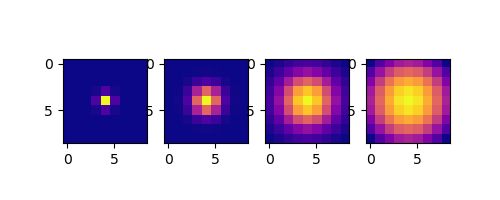

In [2]:
%matplotlib notebook
gauss_kernels_tf = make_gauss_kernels()
show_filter_bank(gauss_kernels_tf)

2020-09-28 15:35:59,163 | INFO : Showing 4 filters in 4 rows


<IPython.core.display.Javascript object>


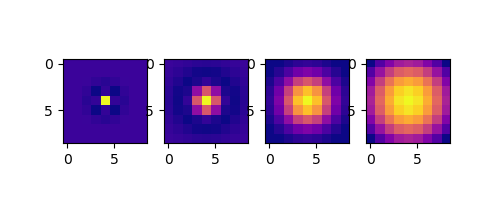

In [3]:
%matplotlib notebook
dog_kernels_tf = make_dog_kernels()
show_filter_bank(dog_kernels_tf)

k=(0.0, 1.0) freq=0.5 phase=0.0
k=(0.0, 1.0) freq=0.5 phase=1.5707963267948966
k=(0.7071067811865476, 0.7071067811865476) freq=0.5 phase=0.0
k=(0.7071067811865476, 0.7071067811865476) freq=0.5 phase=1.5707963267948966
k=(1.0, 6.123233995736766e-17) freq=0.5 phase=0.0
k=(1.0, 6.123233995736766e-17) freq=0.5 phase=1.5707963267948966
k=(0.7071067811865476, -0.7071067811865475) freq=0.5 phase=0.0
k=(0.7071067811865476, -0.7071067811865475) freq=0.5 phase=1.5707963267948966
k=(0.0, 1.0) freq=1.0 phase=0.0
k=(0.0, 1.0) freq=1.0 phase=1.5707963267948966
k=(0.7071067811865476, 0.7071067811865476) freq=1.0 phase=0.0
k=(0.7071067811865476, 0.7071067811865476) freq=1.0 phase=1.5707963267948966
k=(1.0, 6.123233995736766e-17) freq=1.0 phase=0.0
k=(1.0, 6.123233995736766e-17) freq=1.0 phase=1.5707963267948966
k=(0.7071067811865476, -0.7071067811865475) freq=1.0 phase=0.0
k=(0.7071067811865476, -0.7071067811865475) freq=1.0 phase=1.5707963267948966
k=(0.0, 1.0) freq=2.0 phase=0.0
k=(0.0, 1.0) freq=2.

<IPython.core.display.Javascript object>


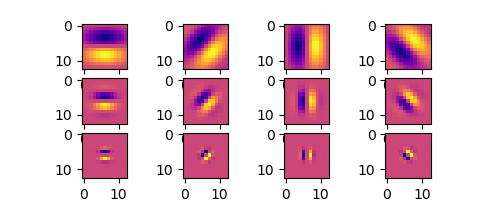

2020-09-28 15:36:02,117 | INFO : 0:0 0
2020-09-28 15:36:02,119 | INFO : 1:0 1
2020-09-28 15:36:02,122 | INFO : 2:0 2
2020-09-28 15:36:02,124 | INFO : 3:0 3
2020-09-28 15:36:02,126 | INFO : 4:1 0
2020-09-28 15:36:02,128 | INFO : 5:1 1
2020-09-28 15:36:02,131 | INFO : 6:1 2
2020-09-28 15:36:02,133 | INFO : 7:1 3
2020-09-28 15:36:02,135 | INFO : 8:2 0
2020-09-28 15:36:02,138 | INFO : 9:2 1
2020-09-28 15:36:02,140 | INFO : 10:2 2
2020-09-28 15:36:02,142 | INFO : 11:2 3
2020-09-28 15:36:02,145 | INFO : Showing 12 filters in 4 rows


<IPython.core.display.Javascript object>


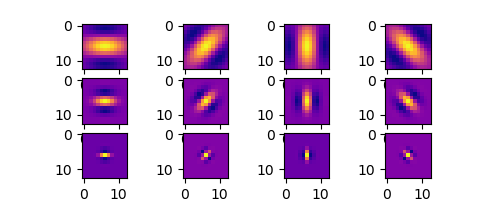

2020-09-28 15:36:02,268 | INFO : 0:0 0
2020-09-28 15:36:02,270 | INFO : 1:0 1
2020-09-28 15:36:02,272 | INFO : 2:0 2
2020-09-28 15:36:02,274 | INFO : 3:0 3
2020-09-28 15:36:02,276 | INFO : 4:1 0
2020-09-28 15:36:02,278 | INFO : 5:1 1
2020-09-28 15:36:02,280 | INFO : 6:1 2
2020-09-28 15:36:02,283 | INFO : 7:1 3
2020-09-28 15:36:02,286 | INFO : 8:2 0
2020-09-28 15:36:02,288 | INFO : 9:2 1
2020-09-28 15:36:02,290 | INFO : 10:2 2
2020-09-28 15:36:02,292 | INFO : 11:2 3


In [4]:
%matplotlib notebook
ks = wave_numbers(4)
gabor_kernels_phi0, gabor_kernels_phi_hpi = \
    make_gabor_kernels(sz=13, ks=ks, freqs=[0.5,1.0,2.0])
logging.info(f"{gabor_kernels_phi0.shape}")
show_filter_bank(gabor_kernels_phi0, rows=3)
show_filter_bank(gabor_kernels_phi_hpi, rows=3)

In [5]:
racoon_path = (Path(os.environ['DATA_ALL']) / 'Misc' / 'racoon').with_suffix('.png')
racoon = imread(racoon_path)
racoon = rgb2gray(racoon)
racoon = resize_img(racoon, sz=128)
racoon = whiten_img(racoon)
racoon = np.reshape(racoon, (1,128,128,1))

2020-09-28 15:36:09,571 | INFO : (1, 128, 128, 12)
2020-09-28 15:36:09,572 | INFO : Showing 12 filters in 4 rows


<IPython.core.display.Javascript object>


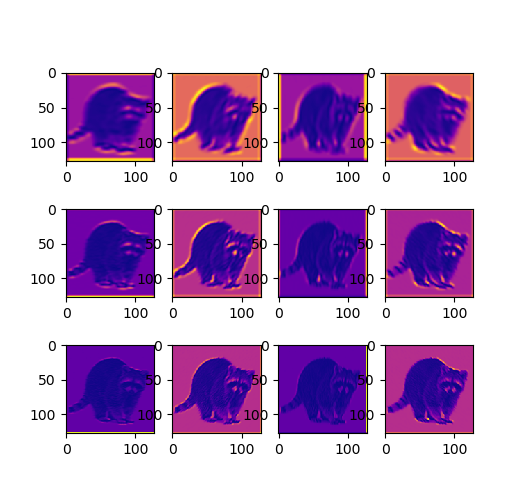

2020-09-28 15:36:09,775 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,777 | INFO : 0:0 0
2020-09-28 15:36:09,780 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,782 | INFO : 1:0 1
2020-09-28 15:36:09,784 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,785 | INFO : 2:0 2
2020-09-28 15:36:09,787 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,788 | INFO : 3:0 3
2020-09-28 15:36:09,791 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,793 | INFO : 4:1 0
2020-09-28 15:36:09,795 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,796 | INFO : 5:1 1
2020-09-28 15:36:09,799 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,800 | INFO : 6:1 2
2020-09-28 15:36:09,802 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:09,804 | INFO : 7:1 3
2020-09-28 15:36:09,806 | INFO : filter_response.shape = (1, 128, 128, 12))
2020

In [6]:
%matplotlib notebook
racoon_in_tf = tf.constant(racoon, dtype=tf.float32)
racoon_out_phi0 = tf.nn.conv2d(racoon_in_tf, # dog_kernels_tf, # 
                               gabor_kernels_phi0,
                               strides=1, padding='SAME')
racoon_out_phi_hpi= tf.nn.conv2d(racoon_in_tf, # dog_kernels_tf, # 
                               gabor_kernels_phi_hpi,
                               strides=1, padding='SAME')
racoon_out_sq = racoon_out_phi0 ** 2 + racoon_out_phi_hpi ** 2

logging.info(racoon_out_sq.shape)
show_filter_response(racoon_out_sq, rows=3)

9.173866e-06


<IPython.core.display.Javascript object>


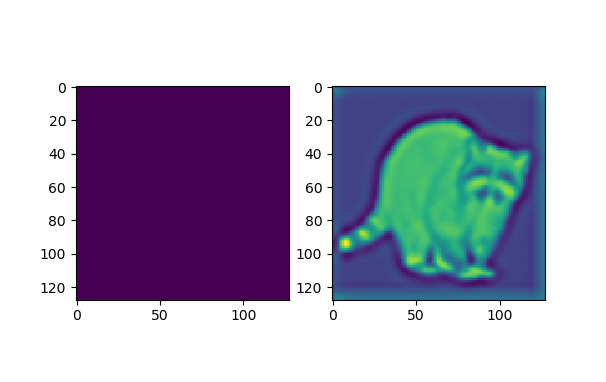

In [7]:
%matplotlib notebook
def mse_tf(current_tf:tf.Tensor, kernel_tf, match_tf_sub:tf.Tensor):
    current_out_tf_phi0 = \
        tf.nn.conv2d(current_tf, kernel_tf[0],
                     strides=1, padding='SAME')
    
    current_out_tf_phi1 = \
        tf.nn.conv2d(current_tf, kernel_tf[1],
                     strides=1, padding='SAME')
    
    current_out_tf_sq = current_out_tf_phi0 ** 2 + current_out_tf_phi1 ** 2
    
    current_out_tf_sub = \
        tf.nn.max_pool(current_out_tf_sq, (2,2), 
                   strides=1, padding='SAME')
    
    loss_per_level = \
        tf.reduce_mean((current_out_tf_sub - match_tf_sub) ** 2, axis=[0,1,2])
    # print(loss_per_level.shape)
    loss = tf.tensordot(loss_per_level, 
                        [4.,4.,4.,4.,
                         2.,2.,2.,2.,
                         1.,1.,1.,1.], 1)
    return loss

sz = 128
current_value = tf.Variable(np.ones((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, 
                         [gabor_kernels_phi0, gabor_kernels_phi_hpi], 
                         #dog_kernels_tf, 
                         racoon_out_sq)
grad = tape.gradient(current_out, current_value)
print(np.max(grad))

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

<IPython.core.display.Javascript object>


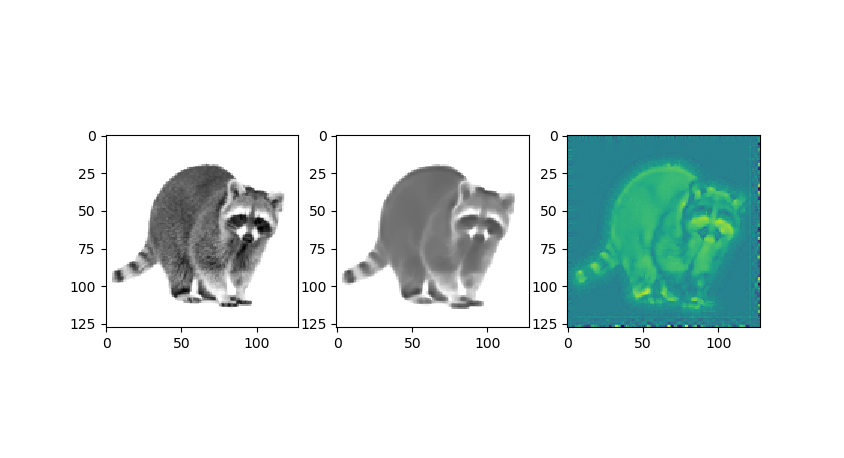

In [8]:
%matplotlib notebook
learning_rate = 1e+3
for n in range(1000):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, 
                             [gabor_kernels_phi0, gabor_kernels_phi_hpi], 
                             # dog_kernels_tf, 
                             racoon_out_sq)
        # tf.print(f"loss = {current_out}   ")
    grad = tape.gradient(current_out, current_value)
fig, axs = plt.subplots(1,3,figsize=(5,3))
axs[0].imshow(tf.reshape(racoon[...,0], (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[1].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[2].imshow(tf.reshape(grad, (sz,sz)))
plt.show()

2020-09-28 15:36:30,599 | INFO : (array([3321,   59,   60,   48,   35,  860, 4647, 1229, 5984,  141],
      dtype=int64), array([29744. , 30109.2, 30474.4, 30839.6, 31204.8, 31570. , 31935.2,
       32300.4, 32665.6, 33030.8, 33396. ]))
2020-09-28 15:36:30,604 | INFO : (array([ 538, 3757, 3360,  964,  977, 1617, 1871, 1865,  953,  482],
      dtype=int64), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
2020-09-28 15:36:30,608 | INFO : Showing 12 filters in 4 rows


<IPython.core.display.Javascript object>


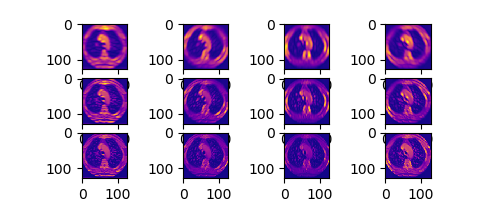

2020-09-28 15:36:30,725 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,726 | INFO : 0:0 0
2020-09-28 15:36:30,728 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,729 | INFO : 1:0 1
2020-09-28 15:36:30,732 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,733 | INFO : 2:0 2
2020-09-28 15:36:30,735 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,737 | INFO : 3:0 3
2020-09-28 15:36:30,739 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,741 | INFO : 4:1 0
2020-09-28 15:36:30,743 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,744 | INFO : 5:1 1
2020-09-28 15:36:30,746 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,748 | INFO : 6:1 2
2020-09-28 15:36:30,750 | INFO : filter_response.shape = (1, 128, 128, 12))
2020-09-28 15:36:30,751 | INFO : 7:1 3
2020-09-28 15:36:30,753 | INFO : filter_response.shape = (1, 128, 128, 12))
2020

In [9]:
%matplotlib notebook
sz = 128
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
slice_path = Path(os.environ['DATA_ALL']) / 'NIH_DeepLesion' \
                    / 'Images_png_01' / 'Images_png' \
                    / '000001_01_01' / '108.png'
transverse_slice = imread(slice_path)
transverse_slice = resize(transverse_slice, (sz,sz))
transverse_slice = img_as_uint(transverse_slice)
logging.info(np.histogram(transverse_slice, 10))

transverse_slice = clahe.apply(transverse_slice)
ts_min, ts_max = np.min(transverse_slice), np.max(transverse_slice)
ts_width = ts_max - ts_min
transverse_slice = (transverse_slice - ts_min) / ts_width
transverse_slice = np.reshape(transverse_slice, (1,sz,sz,1))
logging.info(np.histogram(transverse_slice, 10))

transverse_slice_tf = tf.constant(transverse_slice, dtype=tf.float32)
transverse_slice_out_phi0 = \
    tf.nn.conv2d(transverse_slice_tf,
                 gabor_kernels_phi0,
                 strides=1, padding='SAME')

transverse_slice_out_phi_hpi = \
    tf.nn.conv2d(transverse_slice_tf,
                 gabor_kernels_phi_hpi,
                 strides=1, padding='SAME')

transverse_slice_out_tf_sq = \
    transverse_slice_out_phi0 ** 2 \
        + transverse_slice_out_phi_hpi ** 2

transverse_slice_out_sub = \
    tf.nn.max_pool(transverse_slice_out_tf_sq, (2,2), 
                   strides=1, padding='SAME')

show_filter_response(transverse_slice_out_sub, rows=3)

<IPython.core.display.Javascript object>


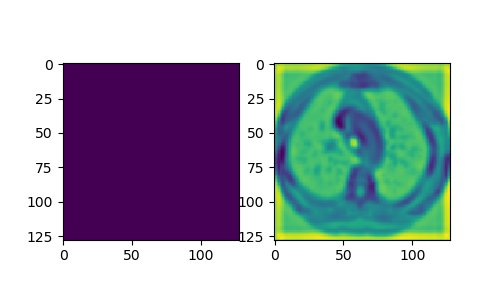

In [10]:
current_value = tf.Variable(0.5 * np.ones((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, 
                         [gabor_kernels_phi0, gabor_kernels_phi_hpi], 
                         transverse_slice_out_sub)
grad = tape.gradient(current_out, current_value)

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

<IPython.core.display.Javascript object>


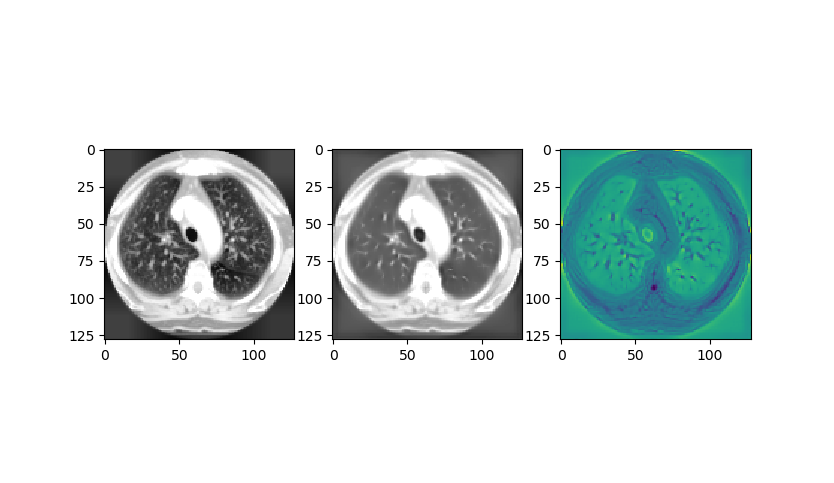

In [11]:
%matplotlib notebook
from IPython.display import clear_output
learning_rate = 1e+3
for n in range(1000):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, 
                             [gabor_kernels_phi0, gabor_kernels_phi_hpi], 
                             transverse_slice_out_sub)
        # tf.print(f"loss = {current_out}   ")
    grad = tape.gradient(current_out, current_value)
    
fig, axs = plt.subplots(1,3,figsize=(5,3))
axs[0].imshow(tf.reshape(transverse_slice[...,0], (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[1].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[2].imshow(tf.reshape(grad, (sz,sz)))